In [41]:
from fastai.collab import * 
import pandas as pd
import codecs
import numpy as np
import json
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [2]:
## import citation data, and only use econ journals for training
df = pd.read_json(codecs.open('data/dblp-ref-1.json', 'r', 'utf-8'), orient = 'columns', lines = True)
temp = df[df['venue'].str.contains('Econ')]
df = pd.read_json(codecs.open('data/dblp-ref-2.json', 'r', 'utf-8'), orient = 'columns', lines = True)
df = df[df['venue'].str.contains('Econ')]
temp = temp.append(df)
df = pd.read_json(codecs.open('data/dblp-ref-0.json', 'r', 'utf-8'), orient = 'columns', lines = True)
df = df[df['venue'].str.contains('Econ')]
temp = temp.append(df)
df = pd.read_json(codecs.open('data/dblp-ref-3.json', 'r', 'utf-8'), orient = 'columns', lines = True)
df = df[df['venue'].str.contains('Econ')]
df = temp.append(df)
len(df)

3137

In [3]:
#print the economics journal titles in the dataset. 
df['venue'].unique()

array(['Information Economics and Policy', 'Games and Economic Behavior', 'Journal of Economic Theory',
       'International Journal of Innovation in The Digital Economy', 'Energy Economics', 'Economics Letters',
       'International Journal of Services, Economics and Management', 'Journal of Economic Education',
       'International Journal of Production Economics', 'European Economic Review', 'Research in Economics',
       'Society and Economy', 'The American Economic Review', 'Journal of Regulatory Economics', 'Economic Theory',
       'Econometrica', 'Journal of Mathematical Economics', 'International Journal of Economic Theory',
       'B E Journal of Theoretical Economics', 'Journal of Economic Geography', 'Resource and Energy Economics',
       'Applied Economics Letters', 'Journal of Economic Psychology', 'Economic Systems Research',
       'Journal of Public Economic Theory', 'arXiv: Economics', 'Economics Bulletin',
       'Journal of Economic Behavior and Organization', 

In [4]:
print(df['year'].min(), df['year'].max())

1989 2017


In [5]:
## references indicates the paper id that cite this paper

In [6]:
df.iloc[1]['references']

['46749b29-cdae-4d73-bd86-d867333e4216',
 'a81ed3de-c0b4-4ca9-96f7-6ede5c5a21e8']

In [7]:
temp = df

In [8]:
## stack the references ids to each paper article.
temp = (temp['references'].apply(lambda x: pd.Series(x))
    .stack()
    .reset_index(level=1, drop=True)
    .to_frame('references')
    .join(temp[['id']], how='left')
    )

In [9]:
len(temp)

8786

In [10]:
temp.head()

,references,id
1519,0d5240ff-33b9-48b7-8a04-776c5d9ad83a,4b3413bb-0d35-44c1-9ea5-6045e9ac78f8
1519,29914249-08ff-4a5a-aafe-048648ebde83,4b3413bb-0d35-44c1-9ea5-6045e9ac78f8
1519,3543a72d-adf3-4f9c-8c65-a11f36e99da6,4b3413bb-0d35-44c1-9ea5-6045e9ac78f8
1519,388b32cf-4c26-4fc6-ab20-24f6236279ac,4b3413bb-0d35-44c1-9ea5-6045e9ac78f8
1519,39c07aca-221e-4231-adbc-1a7c3968ca35,4b3413bb-0d35-44c1-9ea5-6045e9ac78f8


In [11]:
#equal rating for each citation
temp['rating'] = 1 

In [12]:
df2 = CollabDataBunch.from_df(temp, valid_pct = 0.1)

In [13]:
df2.show_batch()

references,id,target
f045bf8a-f8dd-4c60-973c-05854a2361e2,bf9a25bb-b229-427f-919a-462c6d59941b,1.0
37a3c46d-33d3-4db0-b79e-71b5a22cd23c,794779a9-f6e1-49a5-acc4-2bbc88c1d5d2,1.0
39536116-298e-4111-a0cc-de46bbc96632,82577489-c0d7-4ac0-8711-d318006cc303,1.0
426447d2-a64f-41da-aca8-963841616f79,ec861719-9a11-46aa-8cd5-d09cdaac91fa,1.0
7cf1ff89-7a0b-41e3-ab32-f87b51540e49,567bf060-b2ec-480b-bd78-66774461fc1c,1.0


In [14]:
learn = collab_learner(df2, n_factors = 40)

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


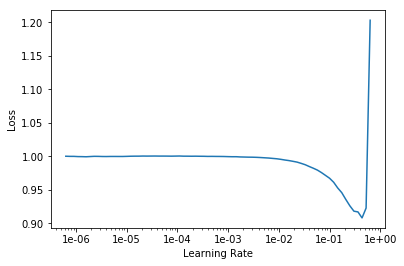

In [16]:
learn.recorder.plot(skip_end = 5)

In [17]:
learn.fit_one_cycle(10, 0.5)

epoch,train_loss,valid_loss,time
0,1.359833,5.509398,00:06
1,604.524231,1298.465210,00:06
2,6502.392090,4933.655273,00:06
3,10734.378906,1679.124268,00:06
4,5873.516113,281.886902,00:06
5,1981.553101,31.736755,00:06
6,385.548828,5.877698,00:05
7,68.260239,2.741859,00:06
8,9.728515,2.132099,00:06
9,2.178745,2.053498,00:06


In [18]:
m = learn.model
m

EmbeddingDotBias(
  (u_weight): Embedding(4538, 40)
  (i_weight): Embedding(2111, 40)
  (u_bias): Embedding(4538, 1)
  (i_bias): Embedding(2111, 1)
)

In [183]:
## the embedding gives a sense of the simiarities between the different movies by their citation patterns.

Fastai library is more suitable for data with varying scale. In this case we have binary data, (either you cited or not, so it may not be very informative). Instead we will follow https://medium.com/radon-dev/item-item-collaborative-filtering-with-binary-or-unary-data-e8f0b465b2c3 

In [19]:
temp = temp.pivot(index = 'references', columns = 'id', values = 'rating')

In [20]:
temp = temp.fillna(0)

In [21]:
print('number of papers citing the other paper:', len(temp.index), 'number of papers being cited:', len(temp.columns))

number of papers citing the other paper: 4864 number of papers being cited: 2167


In [22]:
### Compute Similarity 

In [23]:
magnitude = np.sqrt(np.square(temp).sum(axis=1))

In [24]:
temp = temp.divide(magnitude, axis='index')

In [25]:
def calculate_similarity(data_items):
    """Calculate the column-wise cosine similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    data_sparse = sparse.csr_matrix(data_items)
    similarities = cosine_similarity(data_sparse.transpose())
    sim = pd.DataFrame(data=similarities, index= data_items.columns, columns= data_items.columns)
    return sim

In [26]:
#transposing the matrix such that we use a paper's citation pattern (not how it is being cited) to calculate similarity
data_matrix = calculate_similarity(temp)

In [27]:
#merge the data matrix with df so we know the name of the paper and the meta data

df_comp = pd.merge(data_matrix, df, left_index = True, right_on = 'id')

This paper that is most similar to other papers:

In [28]:
data_matrix.index

Index(['0013b2b5-4c86-43c0-aa1e-fa6dc5a6a6dd',
       '006f888c-f952-40f6-9b43-d4c6d80f55af',
       '00eb22b7-e9b3-4d49-bc31-e5d126083b7a',
       '00fc987e-511e-47ce-aca8-77874c756082',
       '012428be-adf4-476b-8d02-4fc18ad5d8b0',
       '01395447-ee75-4a03-ab0b-995d2402ea97',
       '015eaf44-0a22-4bee-a492-2faa386cfcf8',
       '017280c5-e996-449e-8bd1-90557075dbad',
       '01758cac-89e6-4645-8fcf-5d80e4b20310',
       '0198c227-7833-4cd5-a233-ff22cb4dbd3f',
       ...
       'fe2a1bf8-311a-4697-95d6-76886289638d',
       'fe398551-a89b-400f-9bb2-2bd6f9b6d64a',
       'fe8f54d1-ddf9-4461-8561-83384969b079',
       'febddaab-e411-426e-997d-6028022b7056',
       'fee1cfc2-f5ce-4b7c-9895-24c8efc9edc0',
       'ff0c71d3-92c8-430b-8d4a-88b0cecf11ce',
       'ff328270-5cfa-4fa4-aaa9-e8d9e6d9426b',
       'ff5156f0-dc4c-40e7-a826-e2fb6856b3ec',
       'ff849ede-d3e1-42d6-a7b9-5894bac35ed4',
       'ffe6b018-88da-4673-92b4-b88106d9fccb'],
      dtype='object', name='id', length=2167)

In [39]:
## loop through each paper and save the top 5 papers in a csv

results = {}
for paper in data_matrix.index:
    similar_papers = pd.merge(pd.DataFrame(data_matrix.loc[paper].nlargest(6)),
                      df_comp[['id','title','abstract']],
                      left_index = True,
                      right_on = 'id')['id'].tolist()
    if paper in similar_papers:
        similar_papers.remove(paper)
    results[paper] = similar_papers
    
    
        #drop the row where the id is the same as the one we search 

In [42]:
with open('paper_recommendations.json','w') as fp:
    json.dump(results, fp)

In [265]:
result = pd.merge(pd.DataFrame(data_matrix.loc['0013b2b5-4c86-43c0-aa1e-fa6dc5a6a6dd'].nlargest(11)),
         df_comp[['id','title','abstract']],
         left_index = True,
         right_on = 'id')


,0013b2b5-4c86-43c0-aa1e-fa6dc5a6a6dd,id,title,abstract
774042,1.000000,0013b2b5-4c86-43c0-aa1e-fa6dc5a6a6dd,Hurwicz expected utility and subjective sources,"In experiments, subjects are often not indiffe..."
241038,0.719490,9ab62e30-9124-4aa8-8bff-95d572e19f34,Parametric representation of preferences,A preference is invariant with respect to a se...
442739,0.483677,b249b304-8442-4de4-be89-b7a0bbfaf381,Confidence and decision,Many real-life decisions have to be taken on t...
445995,0.228501,dece2335-936c-4132-8fdb-95e02c855da0,Aggregation of multiple prior opinions,Experts are asked to provide their advice in a...
459818,0.192537,e36bc90d-ae71-4b6d-aae2-6a7d789d11a2,Mean-Dispersion Preferences and Constant Absol...,"We axiomatize, in an Anscombe–Aumann framework..."
450437,0.151980,b41864e2-b6f1-4514-a592-160a75d95e25,A two-parameter model of dispersion aversion,The idea of representing choice under uncertai...
773870,0.141521,15d94138-8542-4389-acba-03a6c4414ebf,Imprecise probabilistic beliefs as a context f...,Coherent imprecise probabilistic beliefs are m...
840209,0.140303,15dbbdb0-60c5-42e4-9f99-248e03685c9f,When does aggregation reduce risk aversion,We study the problem of risk sharing within a ...
938982,0.098655,3c637a2f-13e1-4785-a693-f454c12788e0,Relative concave utility for risk and ambiguity,This paper presents a general technique for co...
121559,0.083188,6702ecf2-0a94-480d-9006-9ceef89b4da3,Uncertainty Averse Preferences,"We study uncertainty averse preferences, that ..."


In [43]:
len(data_matrix)

2167